In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero import (
    simulate_infections_seroreversion,
    simulation_to_regression_df,
    simulation_to_survey_wide,
    get_constant_foi,
    get_constant_foi_survivor
)

from multipathogen_sero.config import PROJ_ROOT, STAN_DIR, MODEL_FITS_DIR

2025-08-29 14:09:29.827 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


# Simulation

In [2]:
n_people = 1000 #number of individuals n
np.random.seed(42)  # For reproducibility
t_max=100
birth_times = np.random.uniform(0, t_max, size=n_people)  # Random birth times for individuals
n_pathogens=2 #number of pathogens K
true_beta_scale = 1.0
pathogen_names = [f'Pathogen {i}' for i in range(1,n_pathogens+1)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]

baseline_hazards = [0.05*k for k in range(1,n_pathogens+1)]  # Example baseline hazards
seroreversion_rates = [0.02 for k in range(1,n_pathogens+1)]  # Example seroreversion rates

foi_list = [
    get_constant_foi(a=baseline_hazards[k]) for k in range(n_pathogens)
]
survivor_list = [
    get_constant_foi_survivor(a=baseline_hazards[k]) for k in range(n_pathogens)
]
# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
beta_mat = np.random.normal(0, true_beta_scale, size=(n_pathogens, n_pathogens)) * interaction_indicator
interaction_mat = np.exp(beta_mat)

# log_frailty_covariance = np.ones((n_pathogens, n_pathogens)) * 0.3

In [3]:
start = time.time()
simulate_infections_seroreversion_df = simulate_infections_seroreversion(
    n_people,
    n_pathogens,
    foi_list,
    interaction_mat=interaction_mat,
    seroreversion_rates=seroreversion_rates,
    birth_times=birth_times,
    #log_frailty_covariance=log_frailty_covariance,
    end_times=t_max,
    max_fois=None,
    random_seed=42
)
print(f"simulate_infections_seroreversion took {time.time() - start:.3f} seconds")


simulate_infections_seroreversion took 0.165 seconds


In [4]:
survey_every = 10.0
survey_times = {
    # i + 1: survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1)
    i+1: np.insert(
        survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1),
        0, birth_times[i]
    )
    for i in range(n_people)
}
survey_wide = simulation_to_survey_wide(
    simulate_infections_seroreversion_df,
    survey_times=survey_times
)
# exclude individuals with only one row in survey_wide
survey_wide = survey_wide.groupby('individual').filter(lambda x: len(x) > 1)
n_nontrivial_individuals = len(survey_wide['individual'].unique())
print("Number of individuals with more than one survey:", n_nontrivial_individuals)

Number of individuals with more than one survey: 1000


# Inference

In [5]:
"""
data {
    int<lower=1> N;                         // Number of individuals
    array[N] int<lower=1> num_tests;                 // Number of serological tests for each individual
    int<lower=1> num_tests_total; // Total number of serological tests across all individuals
    int<lower=1> K;                         // Number of pathogens
    array[num_tests_total] real test_times; // Time of each serological test
    array[num_tests_total,K] int<lower=0, upper=1> serostatus; // Seropositivity for each test and pathogen

    real <lower=0> beta_scale; // scale for Laplace prior on log hazard ratios
}
"""
# TODO: write tests
stan_data = {
    "N": n_nontrivial_individuals,
    "K": n_pathogens,
    "num_tests": survey_wide.groupby('individual').size().values,
    "num_tests_total": len(survey_wide),
    "test_times": survey_wide['time'].values,
    "serostatus": survey_wide[[col for col in survey_wide.columns if col.startswith('serostatus_')]].values.astype(int),  # Convert to int for Stan
    "interval": survey_every,
    "log_baseline_hazard_mean": -1,
    "log_baseline_hazard_scale": 0.5,
    "beta_scale": 1.0,  # scale for Laplace prior on log hazard ratios
}

In [6]:
model = CmdStanModel(
    stan_file=os.path.join(STAN_DIR, "multiplex_serology_seroreversion.stan")
)
fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=200,
    iter_warmup=200,
    parallel_chains=1,
    seed=42,
    show_console=False
)

14:09:47 - cmdstanpy - INFO - compiling stan file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology_seroreversion.stan to exe file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology_seroreversion
14:10:09 - cmdstanpy - INFO - compiled model executable: /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology_seroreversion
14:10:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:40:26 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  log_lik[527]
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more effective parameterization.

Processing complete.

Any R-hat > 1.01? True
Any ESS < 400? True
                               Mean      MCSE    StdDev       MAD  \
lp__                   -5666.760000  0.094345  1.726720  1.504840   
baseline_hazards[1]        0.053250  0.000128  0.003290  0.003066   
baseline_hazards[2]        0.102755  0.000153  0.004258  0.004062   
seroreversion_rates[1]     0.021667  0.000045  0.001182  0

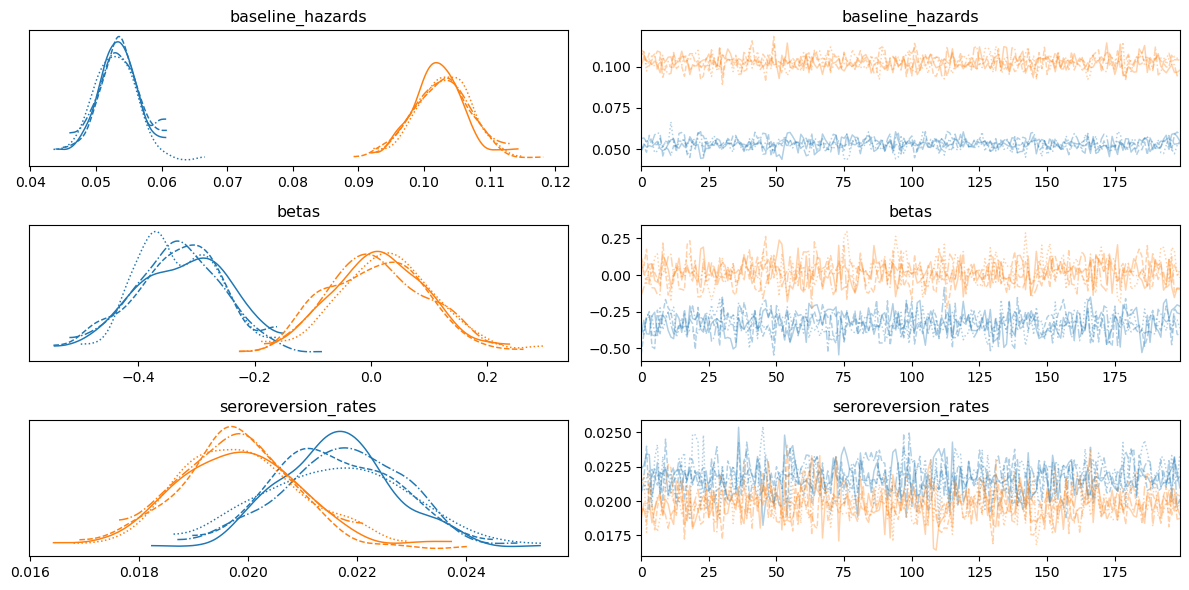

In [7]:
# Print summary
print(fit.diagnose())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())
print(df_summary)

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas", "seroreversion_rates"])
plt.tight_layout()
plt.show()

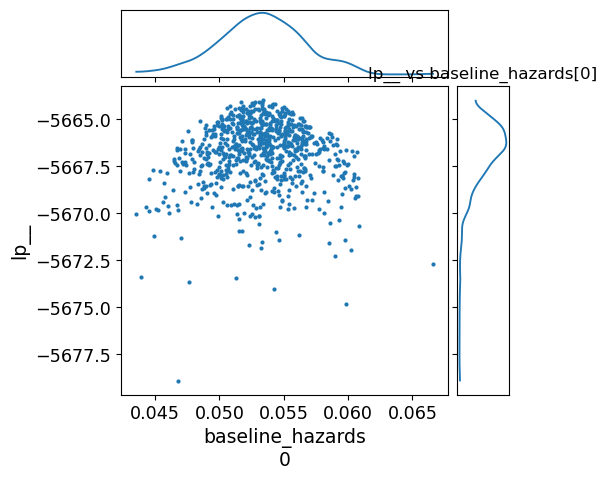

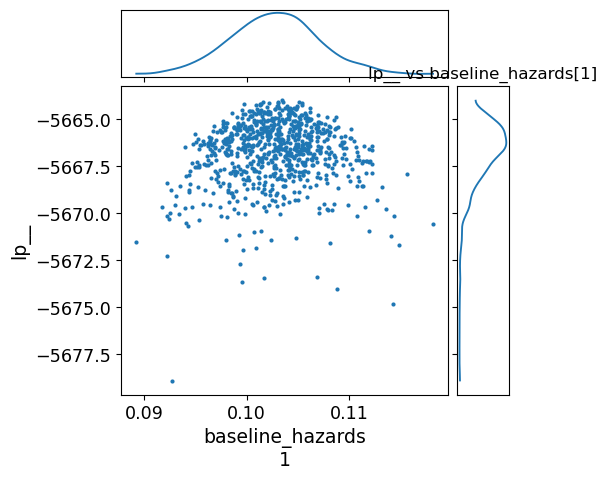

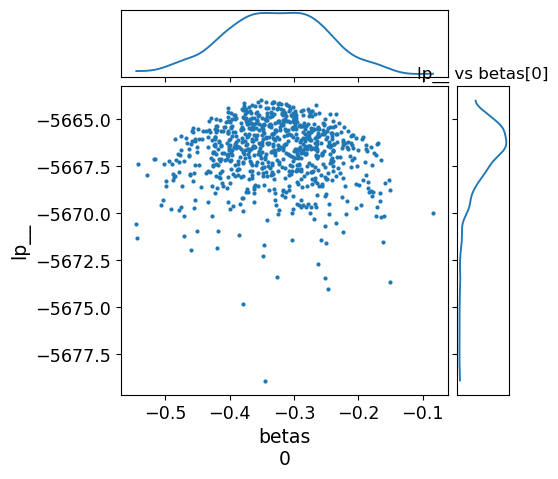

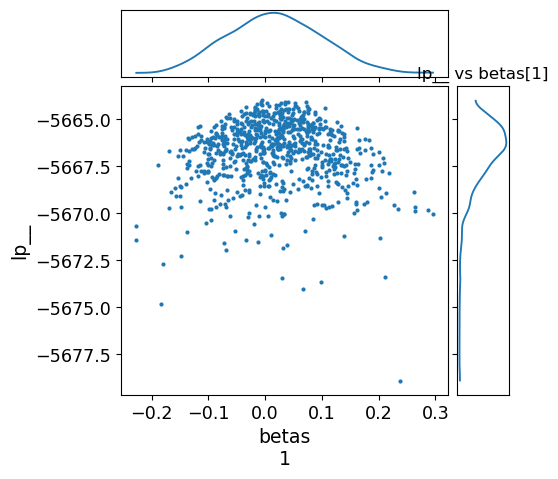

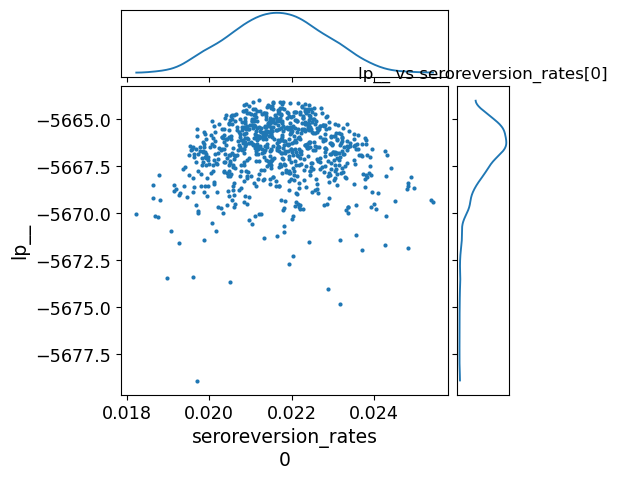

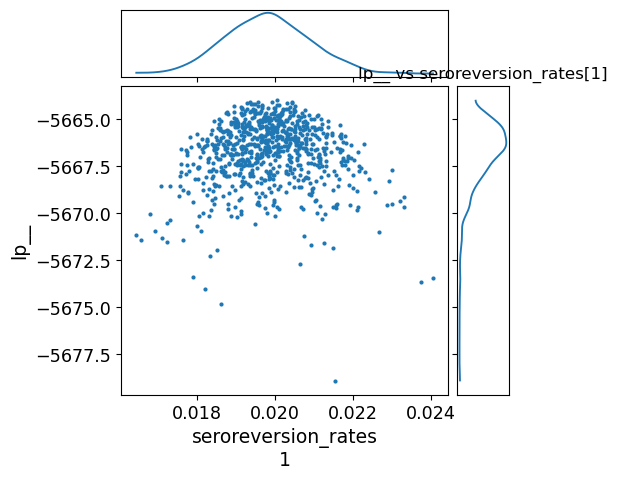

In [8]:

# List your parameter names
param_names = ["baseline_hazards", "betas", "seroreversion_rates"]
import xarray as xr

# Copy lp from sample_stats to posterior as lp__
idata.posterior = xr.merge([idata.posterior, idata.sample_stats[["lp"]].rename({"lp": "lp__"})])

for param in param_names:
    values = idata.posterior[param]
    param_dims = values.dims[2:]  # skip chain and draw
    param_coords = {dim: values.coords[dim].values for dim in param_dims}
    ndim = len(param_dims)

    if ndim == 0:
        # Scalar parameter
        az.plot_pair(
            idata,
            var_names=[param, "lp__"],
            kind="scatter",
            marginals=True,
            figsize=(5, 5),
        )
        plt.title(f"lp__ vs {param}")
        plt.show()
    elif ndim == 1:
        # 1D parameter (vector)
        dim = param_dims[0]
        for idx, coord in enumerate(param_coords[dim]):
            az.plot_pair(
                idata,
                var_names=[param, "lp__"],
                coords={dim: [coord]},
                kind="scatter",
                marginals=True,
                figsize=(5, 5),
            )
            plt.title(f"lp__ vs {param}[{coord}]")
            plt.show()
    elif ndim == 2:
        # 2D parameter (matrix)
        dim0, dim1 = param_dims
        for i, coord0 in enumerate(param_coords[dim0]):
            for j, coord1 in enumerate(param_coords[dim1]):
                az.plot_pair(
                    idata,
                    var_names=[param, "lp__"],
                    coords={dim0: [coord0], dim1: [coord1]},
                    kind="scatter",
                    marginals=True,
                    figsize=(5, 5),
                )
                plt.title(f"lp__ vs {param}[{coord0},{coord1}]")
                plt.show()

True baseline hazards: [0.05, 0.1]


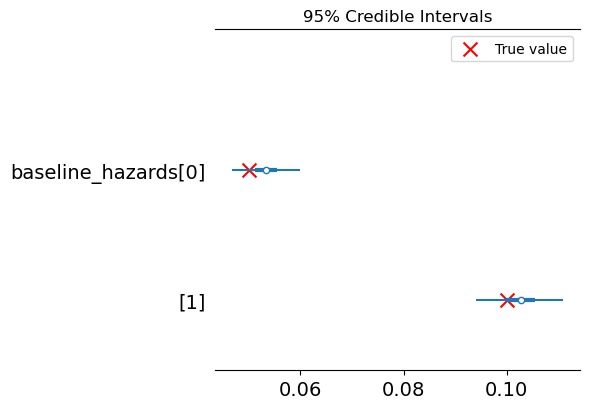

True beta coefficients: [[-0.         -0.23413696]
 [ 0.          0.        ]]


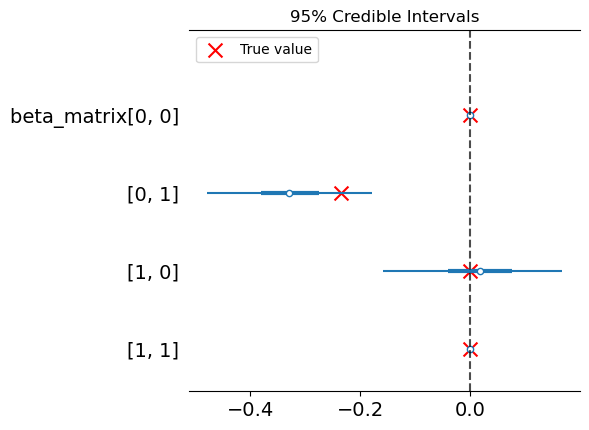

In [9]:
print(f"True baseline hazards: {baseline_hazards}")
axes = az.plot_forest(idata, var_names=["baseline_hazards"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
yticks = ax.get_yticks()
for i, val in enumerate(baseline_hazards[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if len(baseline_hazards) > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {beta_mat}")
axes = az.plot_forest(idata, var_names=["beta_matrix"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
yticks = ax.get_yticks()
for i, val in enumerate(beta_mat.flatten()[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if beta_mat.size > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

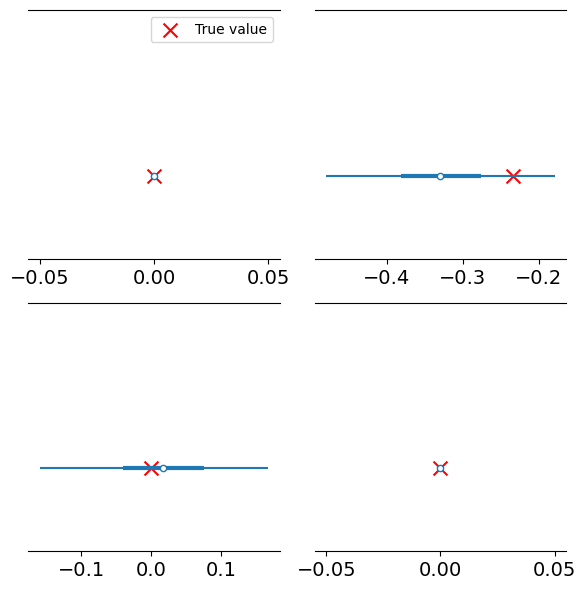

In [10]:
fig, axes = plt.subplots(n_pathogens, n_pathogens, figsize=(3*n_pathogens, 3*n_pathogens), squeeze=False)

for i in range(n_pathogens):
    for j in range(n_pathogens):
        ax = axes[i, j]
        az.plot_forest(
            idata,
            var_names=["beta_matrix"],
            coords={"beta_matrix_dim_0": [i], "beta_matrix_dim_1": [j]},
            hdi_prob=0.95,
            combined=True,
            ax=ax,
            show=False  # Prevents immediate display
        )
        ax.set_yticks([])
        ax.set_title(f"")
        ax.scatter(beta_mat[i, j], 0, marker='x', color='red', s=100, label='True value' if (i == 0 and j == 0) else "")
        if i == 0 and j == 0:
            ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [11]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

Computed from 800 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5661.49   106.01
p_waic        5.76        -
Computed from 800 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5661.52   106.01
p_loo        5.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.66]   (good)     1000  100.0%
   (0.66, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [12]:
import re
import numpy as np

def extract_array_parameters_from_last_draw(fit, chain):
    """
    Extracts all array parameters from the last draw of a CmdStanPy fit,
    reconstructing their original shapes.
    Returns a dictionary: {param_base_name: np.ndarray}
    """
    # Get parameter names (excluding sampler diagnostics)
    param_names = [name for name in fit.column_names if not name.endswith('__')]
    last_draw = fit.draws()[chain, 0, :]  # last draw, first chain
    param_dict = dict(zip(fit.column_names, last_draw))

    arrays = {}
    # Group parameter names by base name and indices
    pattern = re.compile(r"^([^\[]+)\[(.+)\]$")
    grouped = {}
    for name in param_names:
        m = pattern.match(name)
        if m:
            base = m.group(1)
            idx = tuple(int(i) for i in m.group(2).split(','))
            grouped.setdefault(base, []).append((idx, param_dict[name]))
        else:
            arrays[name] = param_dict[name]  # scalar

    # Reconstruct arrays
    for base, items in grouped.items():
        # Find shape
        indices = np.array([idx for idx, _ in items])
        shape = indices.max(axis=0)
        arr = np.empty(shape, dtype=float)
        for idx, value in items:
            arr[tuple(i-1 for i in idx)] = value  # Stan is 1-based
        arrays[base] = arr

    return arrays

# Usage:
arrays = extract_array_parameters_from_last_draw(fit, 0)
for k, v in arrays.items():
    print(f"{k}: {v}\n")

baseline_hazards: [0.0316701 0.0987239]

seroreversion_rates: [0.0234004 0.0248136]

betas: [-0.647886  0.64963 ]

beta_matrix: [[ 0.       -0.647886]
 [ 0.64963   0.      ]]

q_matrix: [[-0.130394   0.0316701  0.0987239  0.       ]
 [ 0.0234004 -0.0750479  0.         0.0516474]
 [ 0.0248136  0.        -0.0854565  0.060643 ]
 [ 0.         0.0248136  0.0234004 -0.048214 ]]

log_lik: [ -7.17458   -1.22926   -5.6418    -4.83474   -4.90366   -9.04432
  -9.38019   -1.41627   -2.87587   -3.86489  -10.13      -1.53008
  -1.9236    -8.52737   -8.54169  -14.7291    -8.58686   -3.53102
  -4.11124   -8.74693   -4.26971   -5.03691   -8.48543   -8.27354
  -4.12995   -2.43504  -11.6977    -4.76456   -7.1755   -11.8628
  -6.18159   -7.08451   -5.98151   -0.621636  -0.428304  -1.68298
 -10.1334    -7.54432   -2.54676   -7.50744   -5.59645   -5.72858
  -7.25722   -1.03467   -7.02821   -2.96434   -7.61929   -5.84459
  -5.66538  -10.3864    -3.60466   -2.38437   -0.725298  -2.06892
  -5.46611   -2.10166 

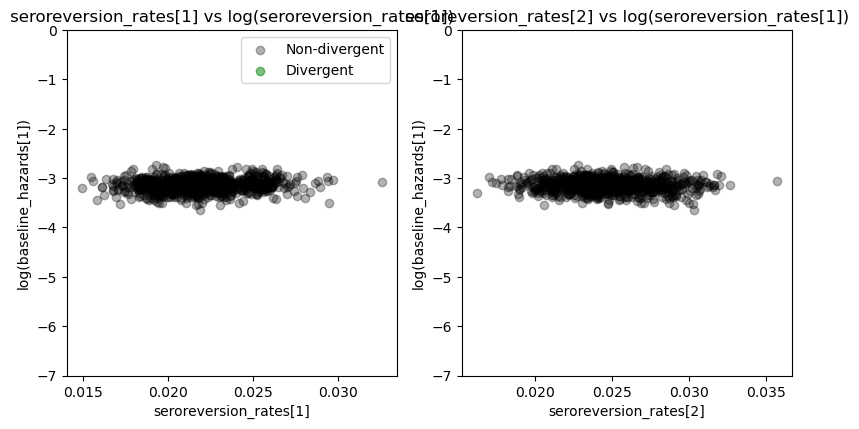

In [13]:
# Extract posterior samples
betas_samples = fit.stan_variable(f'seroreversion_rates')
hazard_samples = fit.stan_variable('baseline_hazards')[:, 0]  # first value

# Get the sampler diagnostics as a DataFrame
diagnostics = fit.draws_pd(vars=['divergent__'])

# Flatten to a 1D boolean mask (True if divergent)
div_mask = diagnostics['divergent__'].values.astype(bool)
nondiv_mask = ~div_mask

plt.figure(figsize=(12, 8))
for k in range(2):
    plt.subplot(2, 3, k+1)
    plt.scatter(
        betas_samples[nondiv_mask, k],
        np.log(hazard_samples[nondiv_mask]),
        color='black', alpha=0.3, label='Non-divergent'
    )
    plt.scatter(
        betas_samples[div_mask, k],
        np.log(hazard_samples[div_mask]),
        color='green', alpha=0.5, label='Divergent'
    )
    plt.xlabel(f'seroreversion_rates[{k+1}]')
    plt.ylabel('log(baseline_hazards[1])')
    plt.title(f'seroreversion_rates[{k+1}] vs log(seroreversion_rates[1])')
    plt.ylim(-7, 0)
    if k == 0:
        plt.legend()

plt.tight_layout()
plt.show()